Datasets loaded:
  staff: (110, 4)
  patients: (1000, 7)
  service: (208, 10)
  schedule: (6552, 6)
Merged dataframe shape: (208, 17)


/tmp/ipython-input-35335589.py:119: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.69905634 -1.69905634 -1.69905634 -1.69905634 -1.63242668 -1.63242668
 -1.63242668 -1.63242668 -1.56579702 -1.56579702 -1.56579702 -1.56579702
 -1.49916736 -1.49916736 -1.49916736 -1.49916736 -1.4325377  -1.4325377
 -1.4325377  -1.4325377  -1.36590804 -1.36590804 -1.36590804 -1.36590804
 -1.29927838 -1.29927838 -1.29927838 -1.29927838 -1.23264872 -1.23264872
 -1.23264872 -1.23264872 -1.16601906 -1.16601906 -1.16601906 -1.16601906
 -1.0993894  -1.0993894  -1.0993894  -1.0993894  -1.03275974 -1.03275974
 -1.03275974 -1.03275974 -0.96613008 -0.96613008 -0.96613008 -0.96613008
 -0.89950042 -0.89950042 -0.89950042 -0.89950042 -0.83287076 -0.83287076
 -0.83287076 -0.83287076 -0.7662411  -0.7662411  -0.7662411  -0.7662411
 -0.69961143 -0.69961143 -0.69961143 -0.69961143 -0.63298177 -0.63298177
 -0.63298177 -0.63298177 -0.56635211 -0.56635

RandomForest - RMSE: 0.0062, MAE: 0.0341, R2: 0.5333


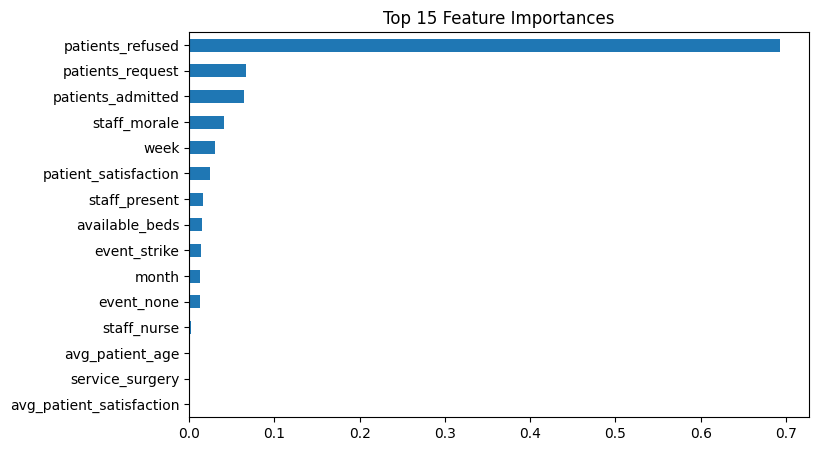


Model and artifacts saved to models/.

‚úÖ Tarih s√ºtunlarƒ± d√∂n√º≈üt√ºr√ºld√º (datetime -> numeric).
‚úÖ Eksik veri dolduruldu.
‚úÖ Model ba≈üarƒ±yla eƒüitildi. Streamlit aray√ºz√º istersen eklenebilir.


In [ ]:
# Hospital Resource Management ML Project (Fixed & Multi-CSV Version)
# --------------------------------------------------------------
# This script integrates four synthetic hospital datasets:
# - hospital_staff.csv
# - hospital_patients.csv
# - hospital_service_weekly.csv
# - hospital_staff_schedule.csv
#
# It predicts weekly hospital occupancy proxy = patients_admitted / available_beds.
# --------------------------------------------------------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib

# -----------------------------
# Config
# -----------------------------
RANDOM_STATE = 42
DATA_DIR = './'  # klas√∂r yolu

# -----------------------------
# Load datasets
# -----------------------------
files = {
    'staff': os.path.join(DATA_DIR, 'staff.csv'),
    'patients': os.path.join(DATA_DIR, 'patients.csv'),
    'service': os.path.join(DATA_DIR, 'services_weekly.csv'),
    'schedule': os.path.join(DATA_DIR, 'staff_schedule.csv')
}

for name, path in files.items():
    if not os.path.exists(path):
        raise FileNotFoundError(f"Eksik dosya: {path}")

df_staff = pd.read_csv(files['staff'])
df_patients = pd.read_csv(files['patients'])
df_service = pd.read_csv(files['service'])
df_schedule = pd.read_csv(files['schedule'])

print('Datasets loaded:')
for n, df in [('staff', df_staff), ('patients', df_patients), ('service', df_service), ('schedule', df_schedule)]:
    print(f"  {n}: {df.shape}")

# -----------------------------
# Create target (occupancy proxy)
# -----------------------------
df_service['occupancy_proxy'] = df_service['patients_admitted'] / df_service['available_beds']
TARGET_COL = 'occupancy_proxy'

# -----------------------------
# Aggregate schedule (weekly staff count per service)
# -----------------------------
staff_counts = df_schedule.groupby(['week', 'service']).agg(staff_present=('present', 'sum')).reset_index()

# -----------------------------
# Merge staff info (count doctors/nurses per service)
# -----------------------------
role_counts = df_staff.groupby(['service', 'role']).size().unstack(fill_value=0).reset_index()
role_counts.columns = ['service'] + [f'staff_{c}' for c in role_counts.columns if c != 'service']

# -----------------------------
# Merge everything into one frame
# -----------------------------
df_merged = df_service.merge(staff_counts, on=['week', 'service'], how='left').merge(role_counts, on='service', how='left')

# Optionally, we could add patient stats (e.g. avg satisfaction per service)
patient_stats = df_patients.groupby('service').agg(
    avg_patient_satisfaction=('satisfaction', 'mean'),
    avg_patient_age=('age', 'mean')
).reset_index()
df_merged = df_merged.merge(patient_stats, on='service', how='left')

print('Merged dataframe shape:', df_merged.shape)

# -----------------------------
# Date handling fix (avoid datetime errors)
# -----------------------------
for col in df_merged.columns:
    if np.issubdtype(df_merged[col].dtype, np.datetime64):
        df_merged[col + '_year'] = df_merged[col].dt.year
        df_merged[col + '_month'] = df_merged[col].dt.month
        df_merged[col + '_day'] = df_merged[col].dt.day
        df_merged[col + '_weekday'] = df_merged[col].dt.weekday
        df_merged.drop(columns=[col], inplace=True)

# -----------------------------
# Preprocessing
# -----------------------------
# Fill missing
for c in df_merged.columns:
    if df_merged[c].isnull().sum() > 0:
        if df_merged[c].dtype in [np.float64, np.int64]:
            df_merged[c] = df_merged[c].fillna(df_merged[c].median())
        else:
            df_merged[c] = df_merged[c].fillna(df_merged[c].mode().iloc[0])

# Categorical encoding
df_encoded = pd.get_dummies(df_merged, columns=['service', 'event'], drop_first=True)

# Feature/Target split
features = [c for c in df_encoded.columns if c != TARGET_COL]
X = df_encoded[features].copy()
y = df_encoded[TARGET_COL].copy()

# Remove datetime and ensure numeric
date_cols = [c for c in X.columns if np.issubdtype(X[c].dtype, np.datetime64)]
X.drop(columns=date_cols, inplace=True, errors='ignore')

numeric_feats = X.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
X.loc[:, numeric_feats] = scaler.fit_transform(X[numeric_feats])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# -----------------------------
# Train model
# -----------------------------
rf = RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RandomForest - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

# -----------------------------
# Feature importance
# -----------------------------
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False).head(15)
plt.figure(figsize=(8,5))
feat_imp.plot(kind='barh')
plt.title('Top 15 Feature Importances')
plt.gca().invert_yaxis()
plt.show()

# -----------------------------
# Save model
# -----------------------------
os.makedirs('models', exist_ok=True)
joblib.dump(rf, 'models/rf_hospital_model.joblib')
joblib.dump(scaler, 'models/scaler.joblib')
with open('models/features.txt', 'w') as f:
    f.write('\n'.join(features))

print('\nModel and artifacts saved to models/.')

# -----------------------------
# Notes
# -----------------------------
print('\n‚úÖ Tarih s√ºtunlarƒ± d√∂n√º≈üt√ºr√ºld√º (datetime -> numeric).')
print('‚úÖ Eksik veri dolduruldu.')
print('‚úÖ Model ba≈üarƒ±yla eƒüitildi. Streamlit aray√ºz√º istersen eklenebilir.')

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Test verisinde tahmin yap
y_pred = rf.predict(X_test)

# Performans metrikleri
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"üìä Model Performansƒ±:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R¬≤: {r2:.4f}")


üìä Model Performansƒ±:
MAE: 0.0341
RMSE: 0.0785
R¬≤: 0.5333


In [ ]:
import pandas as pd

comparison = pd.DataFrame({
    "Ger√ßek": y_test.values,
    "Tahmin": y_pred
})
print(comparison.head(10))


   Ger√ßek    Tahmin
0     1.0  1.000000
1     1.0  1.000000
2     1.0  1.000000
3     1.0  1.000000
4     1.0  1.000000
5     1.0  1.000000
6     1.0  1.000000
7     0.7  0.662916
8     1.0  1.000000
9     1.0  1.000000


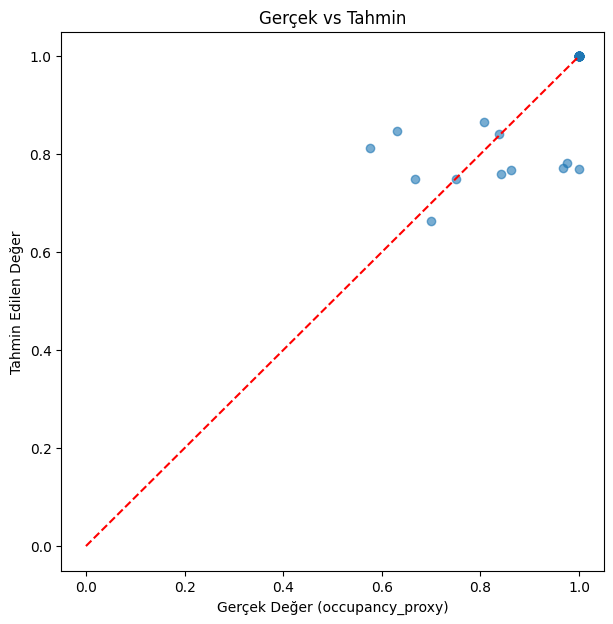

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([0, 1], [0, 1], '--r')
plt.xlabel("Ger√ßek Deƒüer (occupancy_proxy)")
plt.ylabel("Tahmin Edilen Deƒüer")
plt.title("Ger√ßek vs Tahmin")
plt.show()


In [ ]:
new_data = pd.DataFrame([{
    "week": 30,
    "month": 8,
    "service": "emergency",
    "available_beds": 40,
    "patients_request": 70,
    "patients_refused": 20,
    "patient_satisfaction": 75,
    "staff_morale": 80,
    "event": "none",
    # diƒüer gerekli numeric/kategorik s√ºtunlar varsa ekle
}])

# √ñn i≈üleme fonksiyonunu (√∂rneƒüin aynƒ± scaler, encoder) uygula
new_data_encoded = pd.get_dummies(new_data, drop_first=True)

# Eksik kolonlarƒ± tamamla (train'deki X ile aynƒ± s√ºtun sƒ±rasƒ±na g√∂re)
new_data_encoded = new_data_encoded.reindex(columns=X.columns, fill_value=0)

pred = rf.predict(new_data_encoded)
print(f"ü©∫ Tahmini doluluk oranƒ±: {pred[0]:.2f}")


ü©∫ Tahmini doluluk oranƒ±: 1.00


In [ ]:
import joblib

joblib.dump(rf, "/content/hospital_bed_model.pkl")
joblib.dump(scaler, "/content/scaler.pkl")

['/content/scaler.pkl']

In [ ]:
import joblib

# ... after you define 'X'
X_columns = X.columns.tolist()
joblib.dump(X_columns, 'model_columns.pkl')

# ... also save your model
joblib.dump(rf, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [ ]:
# 1. K√ºt√ºphaneleri Y√ºkle
# pydantic kƒ±sƒ±tlamasƒ±nƒ± kaldƒ±rƒ±p versiyon 2+ kuruyoruz.
# Bu, 'google-genai' ve 'langchain' hatalarƒ±nƒ± √ß√∂zecektir.
!pip install fastapi uvicorn "pydantic>=2.0" python-multipart pandas joblib scikit-learn pyngrok --upgrade

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 87.7/87.7 kB 6.5 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 91.2/91.2 kB 6.3 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 108.1/108.1 kB 7.8 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 68.1/68.1 kB 4.9 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 462.4/462.4 kB 26.2 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2.1/2.1 MB 73.2 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

In [ ]:
%%writefile main.py

from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import pandas as pd
import joblib
import os

# --- Model ve S√ºtun Y√ºkleme ---
MODEL_PATH = 'random_forest_model.pkl'
COLUMNS_PATH = 'model_columns.pkl'

rf = None
model_columns = None

try:
    rf = joblib.load(MODEL_PATH)
    model_columns = joblib.load(COLUMNS_PATH)
    print("‚úÖ Model ve s√ºtunlar ba≈üarƒ±yla y√ºklendi (main.py i√ßinden).")
except Exception as e:
    print(f"‚ùå HATA: Model veya s√ºtun dosyalarƒ± y√ºklenemedi (main.py): {e}")

# --- FastAPI Uygulamasƒ± ---
app = FastAPI()

# --- Pydantic Giri≈ü Modeli (Flutter'dan gelen veri) ---
# Pydantic v2'ye uyumlu
class HospitalInput(BaseModel):
    week: int
    month: int
    service: str
    available_beds: float
    patients_request: float
    patients_refused: float
    patient_satisfaction: float
    staff_morale: float
    event: str

# --- K√∂k Endpoint (Test i√ßin) ---
@app.get("/")
def read_root():
    return {"status": "Hospital AI Predictor API is running"}

# --- Tahmin Endpoint'i ---
@app.post("/predict")
async def predict(data: HospitalInput):
    if rf is None or model_columns is None:
        raise HTTPException(status_code=500, detail="Model (rf veya columns) sunucuya y√ºklenemedi.")

    try:
        # √ñNEMLƒ∞ DEƒûƒ∞≈ûƒ∞KLƒ∞K: Pydantic v2'de .dict() yerine .model_dump() kullanƒ±lƒ±r
        data_dict = data.model_dump()
        print(f"\n[INFO] Gelen veri: {data_dict}")

        # Modelinizin beklediƒüi veri i≈üleme adƒ±mlarƒ±
        new_data = pd.DataFrame([data_dict])
        new_data_encoded = pd.get_dummies(new_data, drop_first=True)
        new_data_processed = new_data_encoded.reindex(columns=model_columns, fill_value=0)

        print("[INFO] Model i√ßin i≈ülenmi≈ü veri (ilk satƒ±r):")
        print(new_data_processed.head().to_string())

        # Tahmin
        prediction = rf.predict(new_data_processed)

        # Sonu√ß
        return {"predicted_occupancy": prediction[0]}

    except Exception as e:
        print(f"\n[HATA] Tahmin sƒ±rasƒ±nda sorun: {str(e)}")
        raise HTTPException(status_code=400, detail=f"Veri i≈ülenirken hata olu≈ütu: {str(e)}")

Writing main.py


In [ ]:
import os
import time
from pyngrok import ngrok

# 3. Sunucuyu Arka Planda Ba≈ülat
# "nohup" ve "&" kullanarak sunucuyu arka plana alƒ±yoruz.
print("FastAPI sunucusu arka planda ba≈ülatƒ±lƒ±yor...")
os.system("nohup uvicorn main:app --host 0.0.0.0 --port 8000 &")

# Sunucunun ba≈ülamasƒ± i√ßin 5 saniye bekle
print("Sunucunun ayaƒüa kalkmasƒ± i√ßin 5 saniye bekleniyor...")
time.sleep(5)
print("Sunucu ba≈ülatƒ±ldƒ±.")

# 4. Ngrok T√ºnelini Ba≈ülat
NGROK_AUTH_TOKEN = "34NO4epDeCblgBthWxkVYA8shpH_2Th6RqxC9VK6Zm5pQxvP7" # Token'ƒ±nƒ±z
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

try:
    # Varsa eski t√ºnelleri kapat
    ngrok.disconnect_all()
except Exception as e:
    print(f"T√ºnel kapatƒ±lƒ±rken hata (normal): {e}")

# Yeni t√ºneli a√ß
public_url = ngrok.connect(8000)
print("================================================================================")
print(f"‚úÖ SUNUCU HAZIR!")
print(f"Flutter uygulamanƒ±zda bu adresi kullanƒ±n: {public_url}")
print("================================================================================")
print("\nSunucu loglarƒ±nƒ± (print √ßƒ±ktƒ±larƒ±nƒ±) g√∂rmek i√ßin Colab'deki 'nohup.out' dosyasƒ±na bakabilirsiniz.")

FastAPI sunucusu arka planda ba≈ülatƒ±lƒ±yor...
Sunucunun ayaƒüa kalkmasƒ± i√ßin 5 saniye bekleniyor...
Sunucu ba≈ülatƒ±ldƒ±.
T√ºnel kapatƒ±lƒ±rken hata (normal): module 'pyngrok.ngrok' has no attribute 'disconnect_all'
‚úÖ SUNUCU HAZIR!
Flutter uygulamanƒ±zda bu adresi kullanƒ±n: NgrokTunnel: "https://nonimplicative-maudie-nondeclaratory.ngrok-free.dev" -> "http://localhost:8000"

Sunucu loglarƒ±nƒ± (print √ßƒ±ktƒ±larƒ±nƒ±) g√∂rmek i√ßin Colab'deki 'nohup.out' dosyasƒ±na bakabilirsiniz.
